In [ ]:
# for mounting drive with google colabs
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
··········


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [ ]:
!pip install -q keras

In [ ]:
!ls

adc.json  drive  sample_data


In [ ]:
import sys
import time 
import os
import cv2
import datetime
from PIL import Image
from matplotlib import pyplot as plt
import time
import matplotlib.pyplot as plt
import cv2 as cv
from math import sqrt 
import pandas as pd
import numpy as np
from torchvision import transforms as tfs
import torch
from PIL import Image
import pandas as pd
import numpy as np
% matplotlib inline

# Reading data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/storage/fer/fer2013/fer2013/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


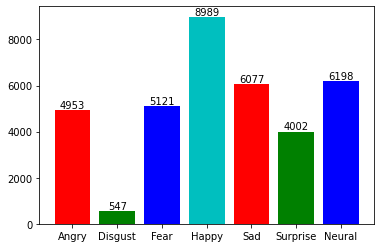

In [ ]:
lab = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neural']
labels_num = data.emotion.value_counts()
la = [0,1,2,3,4,5,6]
la_num = [labels_num[i] for i in range(len(labels_num))]
print(labels_num)
plt.bar(range(len(la_num)), la_num,color='rgbc',tick_label=lab) 
for a,b in zip(la,la_num):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)  
plt.show() 

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64


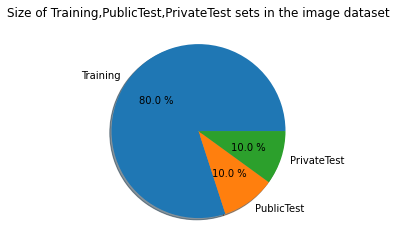

In [ ]:
sets = data.Usage.value_counts()
da = [sets[i] for i in range(len(sets))]
set_la = ['Training','PublicTest','PrivateTest']
print(sets)
plt.axes(aspect=1)
plt.title('Size of Training,PublicTest,PrivateTest sets in the image dataset')
plt.pie(x = da,labels = set_la,autopct='%3.1f %%', shadow=True)
plt.show()

training set: dữ liệu dùng để dạy model học

validation (private test): để đánh giá model hiện tại có tốt không, thường được dùng để chỉnh sửa tham số của model


Test set (public test): là để đánh giá xem model hoạt động với dữ liệu thực tế có tốt không

In [ ]:
train_set = data[(data.Usage == 'Training')] 
val_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')] 
x_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
x_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
x_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 
x_train = x_train.reshape(x_train.shape[0], 48, 48) 
x_val = x_val.reshape(x_val.shape[0],48,48) 
x_test = x_test.reshape(x_test.shape[0],48, 48) 

In [ ]:
y_train = list(train_set.emotion) 
y_val = list(val_set.emotion)
y_test = list(test_set.emotion )

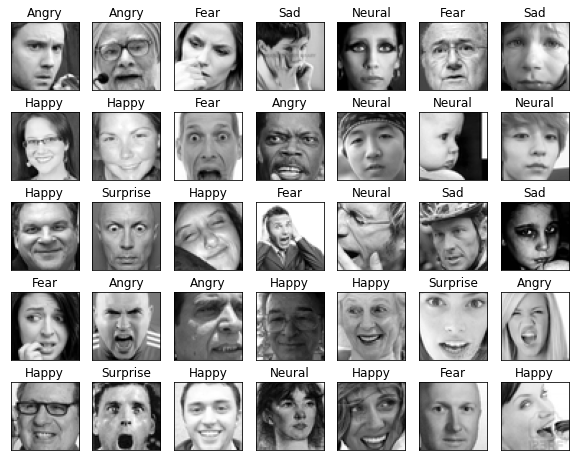

In [ ]:
fig = plt.figure(figsize = (10,8))
for i in range(len(x_train[:35])):
    if(y_train[i] == 0 ):
        str_la = 'Angry'
        img = Image.fromarray(np.uint8(x_train[i]))
    elif(y_train[i] == 1):
        str_la = 'Disgust'
        img = Image.fromarray(np.uint8(x_train[i]))
    elif(y_train[i] == 2):
        str_la = 'Fear'
        img = Image.fromarray(np.uint8(x_train[i]))
    elif(y_train[i] == 3):
        str_la = 'Happy'
        img = Image.fromarray(np.uint8(x_train[i]))
    elif(y_train[i] == 4):
        str_la = 'Sad'
        img = Image.fromarray(np.uint8(x_train[i]))
    elif(y_train[i] == 5):
        str_la = 'Surprise'
        img = Image.fromarray(np.uint8(x_train[i]))
    elif(y_train[i] == 6):
        str_la = 'Neural'
        img = Image.fromarray(np.uint8(x_train[i]))
    y = fig.add_subplot(5,7,i+1)
    y.imshow(img,cmap='gray')
    plt.title(str_la)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

# Data Preprocessing
## Transforming csv to understandable image data

In [ ]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
data_train = data.loc[data['Usage']=='Training']
public_test = data.loc[data['Usage']=='PublicTest']
private_test = data.loc[data['Usage']=='PrivateTest']

In [ ]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)
public_test = shuffle(public_test)
private_test = shuffle(private_test)

In [ ]:
train = np.array(data_train.iloc[:,1])
validation = np.array(private_test.iloc[:,1])
test = np.array(public_test.iloc[:,1])
print(train.shape, test.shape, validation.shape)

(28709,) (3589,) (3589,)


In [ ]:
train = train.reshape(28709,1)
test = test.reshape(3589,1)
validation = validation.reshape(3589,1)

In [ ]:
def data_augmentation(img):
  img = cv2.flip(img.reshape(48,48), 1)
  return np.array(img.reshape(48,48,1)).astype(np.float32)

In [ ]:
# Trying 48,48,3 because of vgg
import cv2
X_train_flip = list()

def reform_data(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48)
  t4 = cv2.cvtColor(t3, cv2.COLOR_GRAY2BGR)
  return t4


def reform_data_aug(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48,48)
  t_1 = data_augmentation(t3)
  t4 = cv2.cvtColor(t3, cv2.COLOR_GRAY2BGR)
  X_train_flip.append(cv2.cvtColor(t_1, cv2.COLOR_GRAY2BGR))
  return t4

X_train_1 = np.apply_along_axis(reform_data_aug, 1, train)
X_train = np.array(list(X_train_1) + X_train_flip)
X_test = np.apply_along_axis(reform_data, 1, test)
X_valid = np.apply_along_axis(reform_data, 1, validation)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(57418, 48, 48, 3)
(3589, 48, 48, 3)
(3589, 48, 48, 3)


### Normalization 

In [ ]:
X_train = X_train/255
X_test = X_test/255
X_valid = X_valid/255

### One Hot Encoding

In [ ]:
Y_train = data_train['emotion']
Y_test = public_test['emotion']
Y_validation = private_test['emotion']

In [ ]:
print(Y_train.shape, Y_test.shape, Y_validation.shape)

(28709,) (3589,) (3589,)


In [ ]:
def onehot(Y, C):
  Y = np.eye(C)[Y].T
  return Y

In [ ]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
Y_test = onehot(Y_test, 7).T
Y_train = onehot(Y_train, 7).T
Y_valid = onehot(Y_validation, 7).T

In [ ]:
Y_train.shape

(28709, 7)

In [ ]:
Y_train = np.array(list(Y_train) + list(Y_train))

In [ ]:
Y_train.shape

(57418, 7)

In [ ]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=2)

In [ ]:
# Clear memory
del data
del data_train
del public_test
del private_test
del Y_validation
del X_train_1
del X_train_flip
del train
del validation
del test

## CNN Models
Taking 3 - 4 models for ensemble voting

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, Conv3D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Adamax
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.regularizers import l2

### 1-Basic 5 layer model

In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
input_shape = (48, 48, 3)

In [ ]:
def Model1(input_shape=(48,48,3)):
  model = Sequential()
  model.add(Conv2D(1, kernel_size=(1, 1), activation='relu', input_shape=input_shape, data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_labels, activation='softmax'))
  return model

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/content/drive/MyDrive/storage/fer/fer2013", monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
model1_2 = Model1()
model1_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 1)         4         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(horizontal_flip=True,
                        vertical_flip=True)
train_generator_1 = gen.flow(X_train, Y_train, batch_size=batch_size)
 
model1_2.compile(loss=categorical_crossentropy , optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7) , metrics=['accuracy']
)
 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history2 = model1_2.fit_generator(train_generator_1, epochs=500, validation_data=(X_valid, Y_valid), shuffle=True, callbacks=[lr_reducer, early_stopper, tensorboard, checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/500
898/898 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.7995
Epoch 00001: val_loss did not improve from 0.95943
898/898 [==============================] - 90s 97ms/step - loss: 0.5646 - accuracy: 0.7995 - val_loss: 1.0120 - val_accuracy: 0.6698 - lr: 1.0000e-04
Epoch 2/500
898/898 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.8016
Epoch 00002: val_loss did not improve from 0.95943
898/898 [==============================] - 88s 97ms/step - loss: 0.5530 - accuracy: 0.8016 - val_loss: 1.0381 - val_accuracy: 0.6682 - lr: 1.0000e-04
Epoch 3/500
898/898 [==============================] - ETA: 0s - loss: 0.5405 - accuracy: 0.8051
Epoch 00003: val_loss did not improve from 0.95943
898/898 [==============================] - 87s 97ms/step - loss: 0.5405 - accuracy: 0.8051 - val_loss: 1.0160 - val_accuracy: 0.6740 - lr: 1.0000e-04
Epoch 4/500
898/898 [==============================] - ETA: 0s - loss: 0.5336 - accuracy: 0.8080
Epoch 000

In [ ]:
model1_2.save("/content/drive/MyDrive/storage/fer/fer2013/models1.h5")

In [ ]:
loss, acc = model1_2.evaluate(X_valid, Y_valid, batch_size=64)
print('test loss: ', loss)
print('test acc: ', acc)

57/57 [==============================] - 2s 32ms/step - loss: 1.0462 - accuracy: 0.6815
test loss:  1.0462092161178589
test acc:  0.6815268993377686


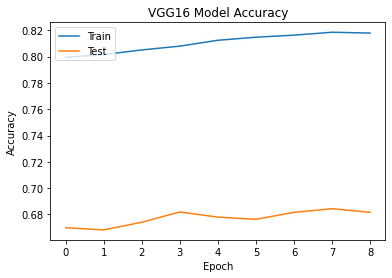

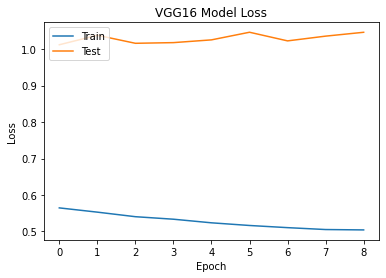

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
frame = cv2.imread('/content/drive/MyDrive/storage/fer/fer2013/images/angry.jpg')

In [ ]:
frame.shape

(683, 1024, 3)

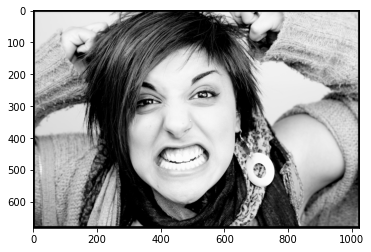

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
faceCascade = cv2.CascadeClassifier('/content/drive/MyDrive/storage/fer/fer2013/haarcascade_frontalface_default.xml')

In [ ]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [ ]:
gray.shape

(683, 1024)

In [ ]:
faces = faceCascade.detectMultiScale(gray, 1.1, 4)
for x, y, w, h in faces:
  roi_gray = gray[y:y+h, x:x+w]
  roi_color = frame[y:y + h, x:x+w]
  cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0 , 0), 2)
  face = faceCascade.detectMultiScale(roi_gray)
  if len(face) == 0:
    print("Face not dectect")
  else:
    for (ex, ey, ew, eh) in face:
      face_roi = roi_color[ey: ey+eh, ex:ex +ew]


Face not dectect


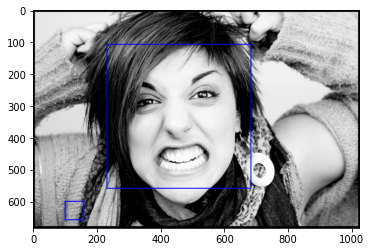

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

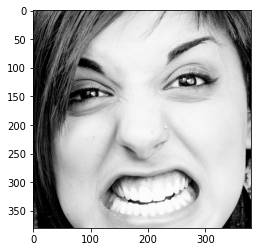

In [ ]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [ ]:
final_image = cv2.resize(face_roi, (48, 48))
final_image = np.expand_dims(final_image, axis=0)
final_image = final_image/255.0

In [ ]:
Predictions = model1_2.predict(final_image)

In [ ]:
EMOTIONS = ["angry", "disgust", "scared","happy", "sad", "surprised", "neutral"]

In [ ]:
Predictions[0]

array([9.55385566e-01, 2.43792706e-03, 4.11247835e-02, 6.53892203e-05,
       8.73192213e-04, 1.02377046e-04, 1.07420610e-05], dtype=float32)

Với model 1 thì acc = 0.67

Với các trọng số khi nhận diện cảm xúc khuôn mặt là:


1.   Angry (Tức giận): 9.871
2.   Disgust (ghê tởm): 2.649
3.   Scared (Sợ hãi): 1.0
4.   Happy (Hạnh phúc): 8.97
5.   Sad (buồn): 1.53
6.   Surpised (Ngạc nhiên): 3.485
7.   Neutral (bình thường): 7.073


In [ ]:
label = EMOTIONS[Predixtions.argmax()]

In [ ]:
print(label)

angry


### Model5 - VGG

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [ ]:
def Model5():
  #tạo model với input là ảnh, lấy output của vgg16 và làm input của các layers fc thêm vào
  vgg = VGG16(include_top=False, input_shape=(48,48,3))
  #Thêm vào các FC layers
  k = Flatten(name = 'flatten')(vgg.output)
  k = Dense(256, activation='relu', name = 'fc1')(k)
  k = Dropout(0.2)(k)
  k = Dense(128, activation='relu', name = 'fc2')(k)
  k = Dropout(0.2)(k)
  k = Dense(64, activation='relu', name = 'fc3')(k)
  #output 7 node và dùng softmax function để chuyển sang xác suất.
  pred = Dense(7, activation='softmax', name = 'predictions')(k)
  model = Model(vgg.input, pred)
  return model

In [ ]:
model5 = Model5()

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
lr_reducer5 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard5 = TensorBoard(log_dir='./logs')
early_stopper5 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer5 = ModelCheckpoint("/content/drive/MyDrive/storage/fer/fer2013/model5", monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
model5.compile(loss=categorical_crossentropy,
              optimizer=Adamax(lr=0.0005),
              metrics=['accuracy'])

In [ ]:
history5 = model5.fit(X_train, Y_train, batch_size = 32,
          epochs=500,
          verbose = 1, 
          validation_data = (X_valid, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer5, tensorboard5, early_stopper5, checkpointer5])

Epoch 1/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5997 - accuracy: 0.3515
Epoch 00001: val_loss improved from inf to 1.29195, saving model to /content/drive/MyDrive/storage/fer/fer2013/model5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model5/assets
1795/1795 [==============================] - 176s 92ms/step - loss: 1.5997 - accuracy: 0.3515 - val_loss: 1.2920 - val_accuracy: 0.5040 - lr: 0.0010
Epoch 2/500
1795/1795 [==============================] - ETA: 0s - loss: 1.2179 - accuracy: 0.5377
Epoch 00002: val_loss improved from 1.29195 to 1.11320, saving model to /content/drive/MyDrive/storage/fer/fer2013/model5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model5/assets
1795/1795 [==============================] - 163s 91ms/step - loss: 1.2179 - accuracy: 0.5377 - val_loss: 1.1132 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 3/500
1795/1795 [==============================] - ETA: 0s - loss: 1.0773 

In [ ]:
# model5.save_weights('drive/face_expr_model5.h5')
model5.save("/content/drive/MyDrive/storage/fer/fer2013/models5.h5")

In [ ]:
loss, acc = model5.evaluate(X_train, Y_train, batch_size=64)
print('test loss: ', loss)
print('test acc: ', acc)

In [ ]:
val_loss, val_acc = model5.evaluate(X_valid, Y_valid, batch_size=64)
print('test val_loss: ', val_loss)
print('test val_acc: ', val_acc)

57/57 [==============================] - 4s 41ms/step - loss: 1.7688 - accuracy: 0.6601
test loss:  1.7687644958496094
test acc:  0.6600724458694458


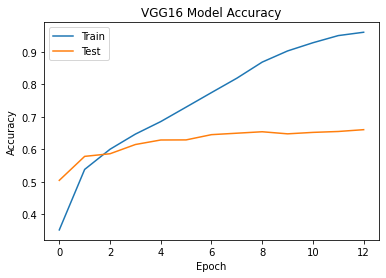

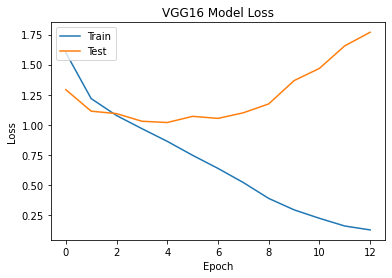

In [ ]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
frame = cv2.imread('/content/drive/MyDrive/storage/fer/fer2013/images/angry.jpg')

In [ ]:
frame.shape

(683, 1024, 3)

In [ ]:
faceCascade = cv2.CascadeClassifier('/content/drive/MyDrive/storage/fer/fer2013/haarcascade_frontalface_default.xml')

In [ ]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [ ]:
faces = faceCascade.detectMultiScale(gray, 1.1, 4)
for x, y, w, h in faces:
  roi_gray = gray[y:y+h, x:x+w]
  roi_color = frame[y:y + h, x:x+w]
  cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0 , 0), 2)
  face = faceCascade.detectMultiScale(roi_gray)
  if len(face) == 0:
    print("Face not dectect")
  else:
    for (ex, ey, ew, eh) in face:
      face_roi = roi_color[ey: ey+eh, ex:ex +ew]

Face not dectect


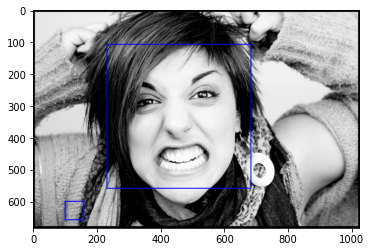

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

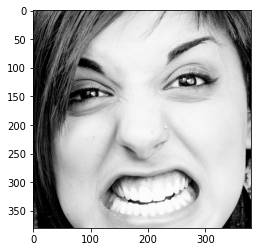

In [ ]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [ ]:
final_image = cv2.resize(face_roi, (48, 48))
final_image = np.expand_dims(final_image, axis=0)
final_image = final_image/255.0

In [ ]:
Predictions = model5.predict(final_image)

In [ ]:
EMOTIONS = ["angry", "disgust", "scared","happy", "sad", "surprised", "neutral"]

In [ ]:
Predictions[0]

array([9.9554211e-01, 2.9071380e-04, 3.8145103e-03, 9.8612109e-05,
       1.4476667e-04, 1.0834430e-04, 8.3959532e-07], dtype=float32)

In [ ]:
label = EMOTIONS[Predictions.argmax()]
print(label)

angry


### Ensemble Average



In [ ]:
from keras import layers
import tensorflow as tf 
import numpy as np 

In [ ]:
model1_2 = load_model("/content/drive/MyDrive/storage/fer/fer2013/models1.h5")
model2 = load_model("/content/drive/MyDrive/storage/fer/fer2013/models2.h5")
model3 = load_model("/content/drive/MyDrive/storage/fer/fer2013/models3.h5")
model5 = load_model("/content/drive/MyDrive/storage/fer/fer2013/models5.h5")

NameError: ignored

In [ ]:
models = [model1_2, model5]
model_input = tf.keras.Input(shape=(48, 48, 3))
# model_input = (48, 48,3)

In [ ]:
def ensemble(models, model_input):
    
    ens_models=[model(model_input) for model in models] 
    yAvg=layers.average(ens_models) 
    modelEns = Model(inputs=model_input, outputs=yAvg,name='ensemble')
    return modelEns
ensemble_model = ensemble(models, model_input)

In [ ]:
ensemble_model.summary()

In [ ]:
ensemble_model.compile(loss=categorical_crossentropy,
              optimizer=Adamax(),
              metrics=['accuracy'])

In [ ]:
ensemble_model.evaluate(X_test, Y_test)

In [ ]:
# ensemble_model.save('drive/face_expr_ensmodel.json')
ensemble_model.save_weights('/content/drive/MyDrive/storage/fer/fer2013/model_ensmodel.h5')

In [ ]:
Predictions = ensemble_model.predict(final_image)

In [ ]:
EMOTIONS = ["angry", "disgust", "scared","happy", "sad", "surprised", "neutral"]

In [ ]:
Predictions[0]

In [ ]:
Predictions[0][0]

In [ ]:
type(Predictions[0])
newPredictions = np.split(Predictions[0], 7)
print(newPredictions)

In [ ]:
label = EMOTIONS[Predictions.argmax()]
print(label)

###attention


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input((48, 48, 3))
base_pretrained_model = VGG16(input_shape =  (48, 48, 3), include_top = False, weights = 'imagenet')

base_pretrained_model.trainable = False

pt_features = base_pretrained_model(in_lay)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
# pt_depth = base_pretrained_model.compute_output_shape(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(7, activation = 'softmax')(dr_steps)
tb_model = Model(inputs = [in_lay], outputs = [out_layer])

tb_model.compile(optimizer = Adamax(lr = 0.0005), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])

tb_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 vgg16 (Functional)             (None, 1, 1, 512)    14714688    ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1, 1, 512)   2048        ['vgg16[0][0]']                  
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [ ]:
lr_reducer6 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard6 = TensorBoard(log_dir='./logs')
early_stopper6 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer6 = ModelCheckpoint("/content/drive/MyDrive/storage/fer/fer2013/model6", monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
history6 = tb_model.fit(X_train,Y_train,
          batch_size=32,
          epochs=500,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer6, tensorboard6, early_stopper6, checkpointer6])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/500
1795/1795 [==============================] - ETA: 0s - loss: 2.2327 - categorical_accuracy: 0.2510
Epoch 00001: val_loss improved from inf to 1.61205, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - 76s 37ms/step - loss: 2.2327 - categorical_accuracy: 0.2510 - val_loss: 1.6121 - val_categorical_accuracy: 0.3703 - lr: 5.0000e-04
Epoch 2/500
1794/1795 [============================>.] - ETA: 0s - loss: 1.8038 - categorical_accuracy: 0.3025
Epoch 00002: val_loss improved from 1.61205 to 1.57994, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 65s 36ms/step - loss: 1.8037 - categorical_accuracy: 0.3025 - val_loss: 1.5799 - val_categorical_accuracy: 0.3773 - lr: 5.0000e-04
Epoch 3/500
   3/1795 [..............................] - ETA: 1:09 - loss: 1.6866 - categorical_accuracy: 0.3542

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.7076 - categorical_accuracy: 0.3268
Epoch 00003: val_loss improved from 1.57994 to 1.57289, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 63s 35ms/step - loss: 1.7076 - categorical_accuracy: 0.3268 - val_loss: 1.5729 - val_categorical_accuracy: 0.3814 - lr: 5.0000e-04
Epoch 4/500
   3/1795 [..............................] - ETA: 1:07 - loss: 1.5658 - categorical_accuracy: 0.3438

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6703 - categorical_accuracy: 0.3399
Epoch 00004: val_loss improved from 1.57289 to 1.56861, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 65s 36ms/step - loss: 1.6703 - categorical_accuracy: 0.3399 - val_loss: 1.5686 - val_categorical_accuracy: 0.3851 - lr: 5.0000e-04
Epoch 5/500
   1/1795 [..............................] - ETA: 1:15 - loss: 1.6137 - categorical_accuracy: 0.4375

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6471 - categorical_accuracy: 0.3488
Epoch 00005: val_loss improved from 1.56861 to 1.55904, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 65s 36ms/step - loss: 1.6471 - categorical_accuracy: 0.3488 - val_loss: 1.5590 - val_categorical_accuracy: 0.3962 - lr: 5.0000e-04
Epoch 6/500
   3/1795 [..............................] - ETA: 1:12 - loss: 1.6653 - categorical_accuracy: 0.2708

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6372 - categorical_accuracy: 0.3522
Epoch 00006: val_loss improved from 1.55904 to 1.55750, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 63s 35ms/step - loss: 1.6372 - categorical_accuracy: 0.3522 - val_loss: 1.5575 - val_categorical_accuracy: 0.3943 - lr: 5.0000e-04
Epoch 7/500
   1/1795 [..............................] - ETA: 1:02 - loss: 1.6618 - categorical_accuracy: 0.3125

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6327 - categorical_accuracy: 0.3574
Epoch 00007: val_loss improved from 1.55750 to 1.55418, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 63s 35ms/step - loss: 1.6327 - categorical_accuracy: 0.3574 - val_loss: 1.5542 - val_categorical_accuracy: 0.3951 - lr: 5.0000e-04
Epoch 8/500
   3/1795 [..............................] - ETA: 1:08 - loss: 1.5572 - categorical_accuracy: 0.4167

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6295 - categorical_accuracy: 0.3578
Epoch 00008: val_loss improved from 1.55418 to 1.54938, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 62s 35ms/step - loss: 1.6295 - categorical_accuracy: 0.3578 - val_loss: 1.5494 - val_categorical_accuracy: 0.3951 - lr: 5.0000e-04
Epoch 9/500
   3/1795 [..............................] - ETA: 1:07 - loss: 1.7312 - categorical_accuracy: 0.3021

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6218 - categorical_accuracy: 0.3603
Epoch 00009: val_loss did not improve from 1.54938
1795/1795 [==============================] - 59s 33ms/step - loss: 1.6218 - categorical_accuracy: 0.3603 - val_loss: 1.5501 - val_categorical_accuracy: 0.3904 - lr: 5.0000e-04
Epoch 10/500
1795/1795 [==============================] - ETA: 0s - loss: 1.6196 - categorical_accuracy: 0.3627
Epoch 00010: val_loss improved from 1.54938 to 1.54359, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 65s 36ms/step - loss: 1.6196 - categorical_accuracy: 0.3627 - val_loss: 1.5436 - val_categorical_accuracy: 0.3954 - lr: 5.0000e-04
Epoch 11/500
   3/1795 [..............................] - ETA: 1:10 - loss: 1.7211 - categorical_accuracy: 0.2917

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6166 - categorical_accuracy: 0.3625
Epoch 00011: val_loss did not improve from 1.54359
1795/1795 [==============================] - 57s 32ms/step - loss: 1.6166 - categorical_accuracy: 0.3625 - val_loss: 1.5440 - val_categorical_accuracy: 0.3970 - lr: 5.0000e-04
Epoch 12/500
1795/1795 [==============================] - ETA: 0s - loss: 1.6178 - categorical_accuracy: 0.3630
Epoch 00012: val_loss improved from 1.54359 to 1.54128, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 65s 36ms/step - loss: 1.6178 - categorical_accuracy: 0.3630 - val_loss: 1.5413 - val_categorical_accuracy: 0.3993 - lr: 5.0000e-04
Epoch 13/500
   3/1795 [..............................] - ETA: 1:10 - loss: 1.6434 - categorical_accuracy: 0.3021

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6159 - categorical_accuracy: 0.3632
Epoch 00013: val_loss improved from 1.54128 to 1.53847, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 65s 36ms/step - loss: 1.6159 - categorical_accuracy: 0.3632 - val_loss: 1.5385 - val_categorical_accuracy: 0.3962 - lr: 5.0000e-04
Epoch 14/500
   3/1795 [..............................] - ETA: 1:09 - loss: 1.5825 - categorical_accuracy: 0.3750

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6120 - categorical_accuracy: 0.3673
Epoch 00014: val_loss improved from 1.53847 to 1.53636, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 66s 37ms/step - loss: 1.6120 - categorical_accuracy: 0.3673 - val_loss: 1.5364 - val_categorical_accuracy: 0.4018 - lr: 5.0000e-04
Epoch 15/500
   3/1795 [..............................] - ETA: 1:09 - loss: 1.5861 - categorical_accuracy: 0.4167

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6082 - categorical_accuracy: 0.3680
Epoch 00015: val_loss did not improve from 1.53636
1795/1795 [==============================] - 57s 32ms/step - loss: 1.6082 - categorical_accuracy: 0.3680 - val_loss: 1.5369 - val_categorical_accuracy: 0.4026 - lr: 5.0000e-04
Epoch 16/500
1795/1795 [==============================] - ETA: 0s - loss: 1.6078 - categorical_accuracy: 0.3661
Epoch 00016: val_loss did not improve from 1.53636
1795/1795 [==============================] - 57s 32ms/step - loss: 1.6078 - categorical_accuracy: 0.3661 - val_loss: 1.5380 - val_categorical_accuracy: 0.3979 - lr: 5.0000e-04
Epoch 17/500
1795/1795 [==============================] - ETA: 0s - loss: 1.6040 - categorical_accuracy: 0.3715
Epoch 00017: val_loss improved from 1.53636 to 1.53502, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6047 - categorical_accuracy: 0.3674
Epoch 00018: val_loss improved from 1.53502 to 1.53470, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 64s 36ms/step - loss: 1.6047 - categorical_accuracy: 0.3674 - val_loss: 1.5347 - val_categorical_accuracy: 0.3982 - lr: 5.0000e-04
Epoch 19/500
   3/1795 [..............................] - ETA: 1:10 - loss: 1.5189 - categorical_accuracy: 0.4688

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6060 - categorical_accuracy: 0.3709
Epoch 00019: val_loss improved from 1.53470 to 1.53468, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 66s 37ms/step - loss: 1.6060 - categorical_accuracy: 0.3709 - val_loss: 1.5347 - val_categorical_accuracy: 0.4046 - lr: 5.0000e-04
Epoch 20/500
   1/1795 [..............................] - ETA: 1:09 - loss: 1.5090 - categorical_accuracy: 0.3438

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6028 - categorical_accuracy: 0.3698
Epoch 00020: val_loss improved from 1.53468 to 1.53138, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 64s 35ms/step - loss: 1.6028 - categorical_accuracy: 0.3698 - val_loss: 1.5314 - val_categorical_accuracy: 0.4043 - lr: 5.0000e-04
Epoch 21/500
   3/1795 [..............................] - ETA: 1:10 - loss: 1.6532 - categorical_accuracy: 0.3646

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.6023 - categorical_accuracy: 0.3715
Epoch 00021: val_loss improved from 1.53138 to 1.53041, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 67s 37ms/step - loss: 1.6023 - categorical_accuracy: 0.3715 - val_loss: 1.5304 - val_categorical_accuracy: 0.4032 - lr: 5.0000e-04
Epoch 22/500
   1/1795 [..............................] - ETA: 1:09 - loss: 1.4384 - categorical_accuracy: 0.4375

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.6011 - categorical_accuracy: 0.3689
Epoch 00022: val_loss improved from 1.53041 to 1.52861, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 64s 36ms/step - loss: 1.6011 - categorical_accuracy: 0.3689 - val_loss: 1.5286 - val_categorical_accuracy: 0.4015 - lr: 5.0000e-04
Epoch 23/500
   1/1795 [..............................] - ETA: 1:11 - loss: 1.5500 - categorical_accuracy: 0.3750

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5978 - categorical_accuracy: 0.3719
Epoch 00023: val_loss did not improve from 1.52861
1795/1795 [==============================] - 58s 32ms/step - loss: 1.5978 - categorical_accuracy: 0.3719 - val_loss: 1.5288 - val_categorical_accuracy: 0.4037 - lr: 5.0000e-04
Epoch 24/500
1795/1795 [==============================] - ETA: 0s - loss: 1.6007 - categorical_accuracy: 0.3705
Epoch 00024: val_loss did not improve from 1.52861
1795/1795 [==============================] - 60s 34ms/step - loss: 1.6007 - categorical_accuracy: 0.3705 - val_loss: 1.5294 - val_categorical_accuracy: 0.4057 - lr: 5.0000e-04
Epoch 25/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5950 - categorical_accuracy: 0.3728
Epoch 00025: val_loss improved from 1.52861 to 1.52543, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5949 - categorical_accuracy: 0.3728
Epoch 00026: val_loss improved from 1.52543 to 1.52478, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 66s 37ms/step - loss: 1.5949 - categorical_accuracy: 0.3728 - val_loss: 1.5248 - val_categorical_accuracy: 0.4071 - lr: 5.0000e-04
Epoch 27/500
   1/1795 [..............................] - ETA: 1:11 - loss: 1.5349 - categorical_accuracy: 0.4375

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5982 - categorical_accuracy: 0.3711
Epoch 00027: val_loss did not improve from 1.52478
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5982 - categorical_accuracy: 0.3711 - val_loss: 1.5254 - val_categorical_accuracy: 0.4023 - lr: 5.0000e-04
Epoch 28/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5946 - categorical_accuracy: 0.3723
Epoch 00028: val_loss did not improve from 1.52478
1795/1795 [==============================] - 61s 34ms/step - loss: 1.5946 - categorical_accuracy: 0.3723 - val_loss: 1.5260 - val_categorical_accuracy: 0.4071 - lr: 5.0000e-04
Epoch 29/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5913 - categorical_accuracy: 0.3767
Epoch 00029: val_loss improved from 1.52478 to 1.52183, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5917 - categorical_accuracy: 0.3745
Epoch 00030: val_loss did not improve from 1.52183
1795/1795 [==============================] - 60s 33ms/step - loss: 1.5917 - categorical_accuracy: 0.3745 - val_loss: 1.5228 - val_categorical_accuracy: 0.4035 - lr: 5.0000e-04
Epoch 31/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5899 - categorical_accuracy: 0.3745
Epoch 00031: val_loss improved from 1.52183 to 1.52119, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 64s 36ms/step - loss: 1.5899 - categorical_accuracy: 0.3745 - val_loss: 1.5212 - val_categorical_accuracy: 0.4032 - lr: 5.0000e-04
Epoch 32/500
   1/1795 [..............................] - ETA: 1:13 - loss: 1.4539 - categorical_accuracy: 0.4062

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5877 - categorical_accuracy: 0.3759
Epoch 00032: val_loss improved from 1.52119 to 1.52002, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 67s 37ms/step - loss: 1.5877 - categorical_accuracy: 0.3759 - val_loss: 1.5200 - val_categorical_accuracy: 0.4071 - lr: 5.0000e-04
Epoch 33/500
   1/1795 [..............................] - ETA: 1:27 - loss: 1.8514 - categorical_accuracy: 0.2812

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5878 - categorical_accuracy: 0.3748
Epoch 00033: val_loss improved from 1.52002 to 1.51894, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 64s 36ms/step - loss: 1.5878 - categorical_accuracy: 0.3748 - val_loss: 1.5189 - val_categorical_accuracy: 0.4104 - lr: 5.0000e-04
Epoch 34/500
   1/1795 [..............................] - ETA: 1:13 - loss: 1.4096 - categorical_accuracy: 0.5312

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5892 - categorical_accuracy: 0.3742
Epoch 00034: val_loss improved from 1.51894 to 1.51729, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 67s 37ms/step - loss: 1.5892 - categorical_accuracy: 0.3742 - val_loss: 1.5173 - val_categorical_accuracy: 0.4099 - lr: 5.0000e-04
Epoch 35/500
   1/1795 [..............................] - ETA: 1:08 - loss: 1.5365 - categorical_accuracy: 0.4688

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5911 - categorical_accuracy: 0.3739
Epoch 00035: val_loss did not improve from 1.51729
1795/1795 [==============================] - 61s 34ms/step - loss: 1.5911 - categorical_accuracy: 0.3739 - val_loss: 1.5179 - val_categorical_accuracy: 0.4071 - lr: 5.0000e-04
Epoch 36/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5863 - categorical_accuracy: 0.3759
Epoch 00036: val_loss improved from 1.51729 to 1.51675, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 64s 36ms/step - loss: 1.5863 - categorical_accuracy: 0.3759 - val_loss: 1.5167 - val_categorical_accuracy: 0.4054 - lr: 5.0000e-04
Epoch 37/500
   1/1795 [..............................] - ETA: 1:08 - loss: 1.5521 - categorical_accuracy: 0.3438

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5865 - categorical_accuracy: 0.3757
Epoch 00037: val_loss improved from 1.51675 to 1.51529, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 67s 37ms/step - loss: 1.5864 - categorical_accuracy: 0.3757 - val_loss: 1.5153 - val_categorical_accuracy: 0.4074 - lr: 5.0000e-04
Epoch 38/500
   1/1795 [..............................] - ETA: 1:10 - loss: 1.6639 - categorical_accuracy: 0.3438

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5868 - categorical_accuracy: 0.3744
Epoch 00038: val_loss did not improve from 1.51529
1795/1795 [==============================] - 61s 34ms/step - loss: 1.5868 - categorical_accuracy: 0.3744 - val_loss: 1.5160 - val_categorical_accuracy: 0.4054 - lr: 5.0000e-04
Epoch 39/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5830 - categorical_accuracy: 0.3782
Epoch 00039: val_loss did not improve from 1.51529
1795/1795 [==============================] - 58s 33ms/step - loss: 1.5830 - categorical_accuracy: 0.3782 - val_loss: 1.5159 - val_categorical_accuracy: 0.4115 - lr: 5.0000e-04
Epoch 40/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5846 - categorical_accuracy: 0.3774
Epoch 00040: val_loss improved from 1.51529 to 1.51489, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5822 - categorical_accuracy: 0.3794
Epoch 00041: val_loss improved from 1.51489 to 1.51420, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 65s 36ms/step - loss: 1.5822 - categorical_accuracy: 0.3794 - val_loss: 1.5142 - val_categorical_accuracy: 0.4062 - lr: 5.0000e-04
Epoch 42/500
   1/1795 [..............................] - ETA: 1:08 - loss: 1.3462 - categorical_accuracy: 0.5938

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5817 - categorical_accuracy: 0.3790
Epoch 00042: val_loss improved from 1.51420 to 1.51101, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 67s 37ms/step - loss: 1.5816 - categorical_accuracy: 0.3791 - val_loss: 1.5110 - val_categorical_accuracy: 0.4068 - lr: 5.0000e-04
Epoch 43/500
   1/1795 [..............................] - ETA: 1:10 - loss: 1.5070 - categorical_accuracy: 0.3438

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5817 - categorical_accuracy: 0.3800
Epoch 00043: val_loss improved from 1.51101 to 1.50968, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 67s 37ms/step - loss: 1.5817 - categorical_accuracy: 0.3800 - val_loss: 1.5097 - val_categorical_accuracy: 0.4138 - lr: 5.0000e-04
Epoch 44/500
   1/1795 [..............................] - ETA: 1:12 - loss: 1.4257 - categorical_accuracy: 0.4375

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5806 - categorical_accuracy: 0.3798
Epoch 00044: val_loss did not improve from 1.50968
1795/1795 [==============================] - 59s 33ms/step - loss: 1.5806 - categorical_accuracy: 0.3798 - val_loss: 1.5108 - val_categorical_accuracy: 0.4113 - lr: 5.0000e-04
Epoch 45/500
1794/1795 [============================>.] - ETA: 0s - loss: 1.5820 - categorical_accuracy: 0.3811
Epoch 00045: val_loss did not improve from 1.50968
1795/1795 [==============================] - 59s 33ms/step - loss: 1.5821 - categorical_accuracy: 0.3811 - val_loss: 1.5118 - val_categorical_accuracy: 0.4076 - lr: 5.0000e-04
Epoch 46/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5819 - categorical_accuracy: 0.3805
Epoch 00046: val_loss improved from 1.50968 to 1.50882, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5797 - categorical_accuracy: 0.3810
Epoch 00047: val_loss did not improve from 1.50882
1795/1795 [==============================] - 61s 34ms/step - loss: 1.5797 - categorical_accuracy: 0.3810 - val_loss: 1.5103 - val_categorical_accuracy: 0.4110 - lr: 5.0000e-04
Epoch 48/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5800 - categorical_accuracy: 0.3789
Epoch 00048: val_loss improved from 1.50882 to 1.50845, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1795/1795 [==============================] - 67s 37ms/step - loss: 1.5800 - categorical_accuracy: 0.3789 - val_loss: 1.5085 - val_categorical_accuracy: 0.4062 - lr: 5.0000e-04
Epoch 49/500
   3/1795 [..............................] - ETA: 1:08 - loss: 1.6319 - categorical_accuracy: 0.3854

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5791 - categorical_accuracy: 0.3801
Epoch 00049: val_loss improved from 1.50845 to 1.50794, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 67s 37ms/step - loss: 1.5791 - categorical_accuracy: 0.3801 - val_loss: 1.5079 - val_categorical_accuracy: 0.4104 - lr: 5.0000e-04
Epoch 50/500
   1/1795 [..............................] - ETA: 1:08 - loss: 1.7925 - categorical_accuracy: 0.3125

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5763 - categorical_accuracy: 0.3806
Epoch 00050: val_loss improved from 1.50794 to 1.50530, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 67s 37ms/step - loss: 1.5763 - categorical_accuracy: 0.3806 - val_loss: 1.5053 - val_categorical_accuracy: 0.4121 - lr: 5.0000e-04
Epoch 51/500
   1/1795 [..............................] - ETA: 1:11 - loss: 1.4862 - categorical_accuracy: 0.4688

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5744 - categorical_accuracy: 0.3812
Epoch 00051: val_loss did not improve from 1.50530
1795/1795 [==============================] - 59s 33ms/step - loss: 1.5745 - categorical_accuracy: 0.3812 - val_loss: 1.5091 - val_categorical_accuracy: 0.4129 - lr: 5.0000e-04
Epoch 52/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5773 - categorical_accuracy: 0.3823
Epoch 00052: val_loss did not improve from 1.50530
1795/1795 [==============================] - 61s 34ms/step - loss: 1.5773 - categorical_accuracy: 0.3823 - val_loss: 1.5062 - val_categorical_accuracy: 0.4157 - lr: 5.0000e-04
Epoch 53/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5744 - categorical_accuracy: 0.3824
Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0004500000213738531.

Epoch 00053: val_loss did not improve from 1.50530
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5744 - categorical_acc

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5743 - categorical_accuracy: 0.3844
Epoch 00056: val_loss did not improve from 1.50314
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5743 - categorical_accuracy: 0.3844 - val_loss: 1.5039 - val_categorical_accuracy: 0.4126 - lr: 4.5000e-04
Epoch 57/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5715 - categorical_accuracy: 0.3832
Epoch 00057: val_loss improved from 1.50314 to 1.50230, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 63s 35ms/step - loss: 1.5715 - categorical_accuracy: 0.3832 - val_loss: 1.5023 - val_categorical_accuracy: 0.4096 - lr: 4.5000e-04
Epoch 58/500
   3/1795 [..............................] - ETA: 1:10 - loss: 1.4383 - categorical_accuracy: 0.4479

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5715 - categorical_accuracy: 0.3837
Epoch 00058: val_loss did not improve from 1.50230
1795/1795 [==============================] - 60s 33ms/step - loss: 1.5715 - categorical_accuracy: 0.3837 - val_loss: 1.5043 - val_categorical_accuracy: 0.4118 - lr: 4.5000e-04
Epoch 59/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5701 - categorical_accuracy: 0.3853
Epoch 00059: val_loss improved from 1.50230 to 1.50209, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 65s 36ms/step - loss: 1.5701 - categorical_accuracy: 0.3853 - val_loss: 1.5021 - val_categorical_accuracy: 0.4168 - lr: 4.5000e-04
Epoch 60/500
   3/1795 [..............................] - ETA: 1:07 - loss: 1.4851 - categorical_accuracy: 0.3646

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5734 - categorical_accuracy: 0.3833
Epoch 00060: val_loss did not improve from 1.50209
1795/1795 [==============================] - 59s 33ms/step - loss: 1.5734 - categorical_accuracy: 0.3833 - val_loss: 1.5038 - val_categorical_accuracy: 0.4138 - lr: 4.5000e-04
Epoch 61/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5736 - categorical_accuracy: 0.3814
Epoch 00061: val_loss improved from 1.50209 to 1.50084, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 67s 37ms/step - loss: 1.5736 - categorical_accuracy: 0.3814 - val_loss: 1.5008 - val_categorical_accuracy: 0.4143 - lr: 4.5000e-04
Epoch 62/500
   1/1795 [..............................] - ETA: 1:09 - loss: 1.3387 - categorical_accuracy: 0.5312

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5714 - categorical_accuracy: 0.3842
Epoch 00062: val_loss did not improve from 1.50084
1795/1795 [==============================] - 61s 34ms/step - loss: 1.5714 - categorical_accuracy: 0.3842 - val_loss: 1.5024 - val_categorical_accuracy: 0.4140 - lr: 4.5000e-04
Epoch 63/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5684 - categorical_accuracy: 0.3853
Epoch 00063: val_loss did not improve from 1.50084
1795/1795 [==============================] - 61s 34ms/step - loss: 1.5684 - categorical_accuracy: 0.3853 - val_loss: 1.5022 - val_categorical_accuracy: 0.4101 - lr: 4.5000e-04
Epoch 64/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5713 - categorical_accuracy: 0.3834
Epoch 00064: val_loss improved from 1.50084 to 1.50047, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5719 - categorical_accuracy: 0.3825
Epoch 00065: val_loss did not improve from 1.50047
1795/1795 [==============================] - 62s 34ms/step - loss: 1.5719 - categorical_accuracy: 0.3825 - val_loss: 1.5006 - val_categorical_accuracy: 0.4166 - lr: 4.5000e-04
Epoch 66/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5709 - categorical_accuracy: 0.3829
Epoch 00066: val_loss did not improve from 1.50047
1795/1795 [==============================] - 62s 34ms/step - loss: 1.5709 - categorical_accuracy: 0.3829 - val_loss: 1.5022 - val_categorical_accuracy: 0.4076 - lr: 4.5000e-04
Epoch 67/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5693 - categorical_accuracy: 0.3862
Epoch 00067: val_loss improved from 1.50047 to 1.50028, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5683 - categorical_accuracy: 0.3856
Epoch 00068: val_loss did not improve from 1.50028
1795/1795 [==============================] - 60s 33ms/step - loss: 1.5683 - categorical_accuracy: 0.3856 - val_loss: 1.5005 - val_categorical_accuracy: 0.4115 - lr: 4.5000e-04
Epoch 69/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5708 - categorical_accuracy: 0.3860
Epoch 00069: val_loss did not improve from 1.50028
1795/1795 [==============================] - 62s 34ms/step - loss: 1.5708 - categorical_accuracy: 0.3860 - val_loss: 1.5018 - val_categorical_accuracy: 0.4149 - lr: 4.5000e-04
Epoch 70/500
1794/1795 [============================>.] - ETA: 0s - loss: 1.5665 - categorical_accuracy: 0.3869
Epoch 00070: val_loss improved from 1.50028 to 1.49875, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5686 - categorical_accuracy: 0.3869
Epoch 00071: val_loss did not improve from 1.49875
1795/1795 [==============================] - 60s 33ms/step - loss: 1.5686 - categorical_accuracy: 0.3869 - val_loss: 1.4991 - val_categorical_accuracy: 0.4154 - lr: 4.5000e-04
Epoch 72/500
1794/1795 [============================>.] - ETA: 0s - loss: 1.5696 - categorical_accuracy: 0.3848
Epoch 00072: val_loss did not improve from 1.49875
1795/1795 [==============================] - 60s 33ms/step - loss: 1.5697 - categorical_accuracy: 0.3848 - val_loss: 1.5010 - val_categorical_accuracy: 0.4140 - lr: 4.5000e-04
Epoch 73/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5670 - categorical_accuracy: 0.3873
Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0004050000192364678.

Epoch 00073: val_loss did not improve from 1.49875
1795/1795 [==============================] - 58s 32ms/step - loss: 1.5670 - categorical_acc

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5649 - categorical_accuracy: 0.3877
Epoch 00076: val_loss did not improve from 1.49849
1795/1795 [==============================] - 61s 34ms/step - loss: 1.5649 - categorical_accuracy: 0.3877 - val_loss: 1.5000 - val_categorical_accuracy: 0.4146 - lr: 4.0500e-04
Epoch 77/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5691 - categorical_accuracy: 0.3843
Epoch 00077: val_loss did not improve from 1.49849
1795/1795 [==============================] - 60s 33ms/step - loss: 1.5691 - categorical_accuracy: 0.3843 - val_loss: 1.5000 - val_categorical_accuracy: 0.4152 - lr: 4.0500e-04
Epoch 78/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5678 - categorical_accuracy: 0.3886
Epoch 00078: val_loss improved from 1.49849 to 1.49763, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5655 - categorical_accuracy: 0.3848
Epoch 00079: val_loss did not improve from 1.49763
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5655 - categorical_accuracy: 0.3848 - val_loss: 1.4994 - val_categorical_accuracy: 0.4146 - lr: 4.0500e-04
Epoch 80/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5633 - categorical_accuracy: 0.3887
Epoch 00080: val_loss did not improve from 1.49763
1795/1795 [==============================] - 60s 33ms/step - loss: 1.5633 - categorical_accuracy: 0.3887 - val_loss: 1.4988 - val_categorical_accuracy: 0.4132 - lr: 4.0500e-04
Epoch 81/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5655 - categorical_accuracy: 0.3838
Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.0003645000251708552.

Epoch 00081: val_loss improved from 1.49763 to 1.49762, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Asse

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5636 - categorical_accuracy: 0.3876
Epoch 00082: val_loss improved from 1.49762 to 1.49680, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 63s 35ms/step - loss: 1.5636 - categorical_accuracy: 0.3876 - val_loss: 1.4968 - val_categorical_accuracy: 0.4154 - lr: 3.6450e-04
Epoch 83/500
   1/1795 [..............................] - ETA: 1:20 - loss: 1.5846 - categorical_accuracy: 0.4688

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5664 - categorical_accuracy: 0.3873
Epoch 00083: val_loss did not improve from 1.49680
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5664 - categorical_accuracy: 0.3873 - val_loss: 1.4978 - val_categorical_accuracy: 0.4115 - lr: 3.6450e-04
Epoch 84/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5643 - categorical_accuracy: 0.3880
Epoch 00084: val_loss did not improve from 1.49680
1795/1795 [==============================] - 60s 33ms/step - loss: 1.5643 - categorical_accuracy: 0.3880 - val_loss: 1.4999 - val_categorical_accuracy: 0.4115 - lr: 3.6450e-04
Epoch 85/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5608 - categorical_accuracy: 0.3891
Epoch 00085: val_loss improved from 1.49680 to 1.49632, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5623 - categorical_accuracy: 0.3914
Epoch 00086: val_loss did not improve from 1.49632
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5623 - categorical_accuracy: 0.3914 - val_loss: 1.4964 - val_categorical_accuracy: 0.4177 - lr: 3.6450e-04
Epoch 87/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5636 - categorical_accuracy: 0.3892
Epoch 00087: val_loss improved from 1.49632 to 1.49447, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 63s 35ms/step - loss: 1.5636 - categorical_accuracy: 0.3892 - val_loss: 1.4945 - val_categorical_accuracy: 0.4177 - lr: 3.6450e-04
Epoch 88/500
   3/1795 [..............................] - ETA: 1:07 - loss: 1.4934 - categorical_accuracy: 0.4271

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5656 - categorical_accuracy: 0.3833
Epoch 00088: val_loss did not improve from 1.49447
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5657 - categorical_accuracy: 0.3833 - val_loss: 1.4964 - val_categorical_accuracy: 0.4143 - lr: 3.6450e-04
Epoch 89/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5627 - categorical_accuracy: 0.3881
Epoch 00089: val_loss improved from 1.49447 to 1.49371, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 65s 36ms/step - loss: 1.5627 - categorical_accuracy: 0.3881 - val_loss: 1.4937 - val_categorical_accuracy: 0.4163 - lr: 3.6450e-04
Epoch 90/500
   3/1795 [..............................] - ETA: 1:07 - loss: 1.5529 - categorical_accuracy: 0.3542

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1793/1795 [============================>.] - ETA: 0s - loss: 1.5637 - categorical_accuracy: 0.3866
Epoch 00090: val_loss did not improve from 1.49371
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5637 - categorical_accuracy: 0.3865 - val_loss: 1.4941 - val_categorical_accuracy: 0.4177 - lr: 3.6450e-04
Epoch 91/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5618 - categorical_accuracy: 0.3876
Epoch 00091: val_loss did not improve from 1.49371
1795/1795 [==============================] - 58s 32ms/step - loss: 1.5618 - categorical_accuracy: 0.3876 - val_loss: 1.4949 - val_categorical_accuracy: 0.4157 - lr: 3.6450e-04
Epoch 92/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5621 - categorical_accuracy: 0.3903
Epoch 00092: ReduceLROnPlateau reducing learning rate to 0.0003280500357504934.

Epoch 00092: val_loss did not improve from 1.49371
1795/1795 [==============================] - 60s 33ms/step - loss: 1.5621 - categorical_acc

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5614 - categorical_accuracy: 0.3872
Epoch 00098: val_loss did not improve from 1.49309
1795/1795 [==============================] - 60s 33ms/step - loss: 1.5614 - categorical_accuracy: 0.3872 - val_loss: 1.4953 - val_categorical_accuracy: 0.4182 - lr: 2.9525e-04
Epoch 99/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5637 - categorical_accuracy: 0.3900
Epoch 00099: val_loss did not improve from 1.49309
1795/1795 [==============================] - 57s 32ms/step - loss: 1.5637 - categorical_accuracy: 0.3900 - val_loss: 1.4962 - val_categorical_accuracy: 0.4152 - lr: 2.9525e-04
Epoch 100/500
1794/1795 [============================>.] - ETA: 0s - loss: 1.5603 - categorical_accuracy: 0.3904
Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.00026572052738629284.

Epoch 00100: val_loss did not improve from 1.49309
1795/1795 [==============================] - 60s 33ms/step - loss: 1.5603 - categorical_a

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5570 - categorical_accuracy: 0.3951
Epoch 00102: val_loss did not improve from 1.49175
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5570 - categorical_accuracy: 0.3951 - val_loss: 1.4931 - val_categorical_accuracy: 0.4207 - lr: 2.6572e-04
Epoch 103/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5585 - categorical_accuracy: 0.3885
Epoch 00103: val_loss did not improve from 1.49175
1795/1795 [==============================] - 61s 34ms/step - loss: 1.5585 - categorical_accuracy: 0.3885 - val_loss: 1.4929 - val_categorical_accuracy: 0.4185 - lr: 2.6572e-04
Epoch 104/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5602 - categorical_accuracy: 0.3883
Epoch 00104: ReduceLROnPlateau reducing learning rate to 0.00023914847988635302.

Epoch 00104: val_loss did not improve from 1.49175
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5602 - categorical_

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1794/1795 [============================>.] - ETA: 0s - loss: 1.5562 - categorical_accuracy: 0.3887
Epoch 00108: val_loss improved from 1.49171 to 1.49059, saving model to /content/drive/MyDrive/storage/fer/fer2013/model6
INFO:tensorflow:Assets written to: /content/drive/MyDrive/storage/fer/fer2013/model6/assets
1795/1795 [==============================] - 66s 37ms/step - loss: 1.5562 - categorical_accuracy: 0.3887 - val_loss: 1.4906 - val_categorical_accuracy: 0.4177 - lr: 2.1523e-04
Epoch 109/500
   1/1795 [..............................] - ETA: 1:09 - loss: 1.3387 - categorical_accuracy: 0.5312

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5540 - categorical_accuracy: 0.3942
Epoch 00109: val_loss did not improve from 1.49059
1795/1795 [==============================] - 58s 32ms/step - loss: 1.5540 - categorical_accuracy: 0.3942 - val_loss: 1.4908 - val_categorical_accuracy: 0.4174 - lr: 2.1523e-04
Epoch 110/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5530 - categorical_accuracy: 0.3937
Epoch 00110: val_loss did not improve from 1.49059
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5530 - categorical_accuracy: 0.3937 - val_loss: 1.4910 - val_categorical_accuracy: 0.4191 - lr: 2.1523e-04
Epoch 111/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5563 - categorical_accuracy: 0.3913
Epoch 00111: ReduceLROnPlateau reducing learning rate to 0.00019371026137378068.

Epoch 00111: val_loss did not improve from 1.49059
1795/1795 [==============================] - 58s 32ms/step - loss: 1.5563 - categorical_

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1795/1795 [==============================] - ETA: 0s - loss: 1.5555 - categorical_accuracy: 0.3916
Epoch 00113: val_loss did not improve from 1.48937
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5555 - categorical_accuracy: 0.3916 - val_loss: 1.4919 - val_categorical_accuracy: 0.4160 - lr: 1.9371e-04
Epoch 114/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5582 - categorical_accuracy: 0.3903
Epoch 00114: val_loss did not improve from 1.48937
1795/1795 [==============================] - 58s 33ms/step - loss: 1.5582 - categorical_accuracy: 0.3903 - val_loss: 1.4918 - val_categorical_accuracy: 0.4182 - lr: 1.9371e-04
Epoch 115/500
1795/1795 [==============================] - ETA: 0s - loss: 1.5530 - categorical_accuracy: 0.3912
Epoch 00115: ReduceLROnPlateau reducing learning rate to 0.00017433923785574736.

Epoch 00115: val_loss did not improve from 1.48937
1795/1795 [==============================] - 60s 34ms/step - loss: 1.5530 - categorical_

In [ ]:
# tb_model.save_mo
tb_model.save("/content/drive/MyDrive/storage/fer/fer2013/models6.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
loss, acc = tb_model.evaluate(X_train, Y_train, batch_size=64)
print('test loss: ', loss)
print('test acc: ', acc)

898/898 [==============================] - 38s 42ms/step - loss: 1.4423 - categorical_accuracy: 0.4516
test loss:  1.4422580003738403
test acc:  0.4515831172466278


In [ ]:
val_loss, val_acc = tb_model.evaluate(X_valid, Y_valid, batch_size=64)
print('test val_loss: ', val_loss)
print('test val_acc: ', val_acc)

57/57 [==============================] - 3s 44ms/step - loss: 1.4905 - categorical_accuracy: 0.4210
test val_loss:  1.4905370473861694
test val_acc:  0.4210086464881897


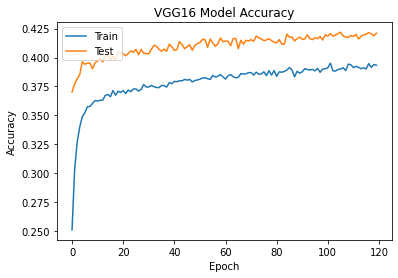

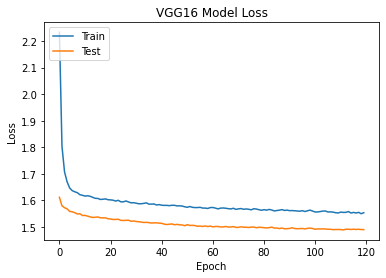

In [ ]:
plt.plot(history6.history['categorical_accuracy'])
plt.plot(history6.history['val_categorical_accuracy'])
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
for attn_layer in tb_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

In [ ]:
import keras.backend as K
rand_idx = np.random.choice(range(len(X_valid)), size = 6)
pt_features = tb_model(in_lay)
attn_func = K.function(inputs = [tb_model.get_input_at(0), K.learning_phase()], 
                       outputs = [attn_layer.get_output_at(0)])
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_age = boneage_div*test_Y[c_idx]+boneage_mean
    img_ax.set_title('Hand Image\nAge:%2.2fY' % (real_age/12))
    pred_age = boneage_div*bone_age_model.predict(cur_img)+boneage_mean
    attn_ax.set_title('Attention Map\nPred:%2.2fY' % (pred_age/12))
fig.savefig('attention_map.png', dpi = 300)

VGG19

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

In [ ]:
vgg19 = VGG19(weights=None, include_top=False, input_shape=(48, 48, 3))

model7 = Sequential()
model7.add(vgg19)
model7.add(Flatten())
model7.add(Dense(7, kernel_initializer='normal', activation='softmax'))
model7.compile(loss = 'mean_squared_error', optimizer=Adamax(lr = 0.0005), metrics = ['accuracy'])

aug = ImageDataGenerator(rotation_range=25,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")
model7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 20,027,975
Trainable params: 20,027,975
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [ ]:
filename='model_train_new.csv'
filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"
vgg_model_bs = 16
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopper7 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
callbacks_list = [csv_log, early_stopper7,checkpoint]
callbacks_list = [csv_log]

In [ ]:
vgg_model_result = model7.fit_generator(aug.flow(X_train, Y_train, batch_size=vgg_model_bs),
                                       validation_data=(X_test, Y_test),
                                       steps_per_epoch=len(X_train) // vgg_model_bs,
                                       epochs=20,
                                       verbose=1,
                                       callbacks = callbacks_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
3588/3588 [==============================] - 307s 82ms/step - loss: 0.1179 - accuracy: 0.2535 - val_loss: 0.1139 - val_accuracy: 0.2995
Epoch 2/20
3588/3588 [==============================] - 293s 82ms/step - loss: 0.1092 - accuracy: 0.3351 - val_loss: 0.0965 - val_accuracy: 0.4140
Epoch 3/20
3588/3588 [==============================] - 293s 82ms/step - loss: 0.0986 - accuracy: 0.4117 - val_loss: 0.0933 - val_accuracy: 0.4514
Epoch 4/20
3588/3588 [==============================] - 294s 82ms/step - loss: 0.0922 - accuracy: 0.4657 - val_loss: 0.0891 - val_accuracy: 0.4943
Epoch 5/20
3588/3588 [==============================] - 293s 82ms/step - loss: 0.0871 - accuracy: 0.5096 - val_loss: 0.0823 - val_accuracy: 0.5506
Epoch 6/20
3588/3588 [==============================] - 292s 81ms/step - loss: 0.0835 - accuracy: 0.5396 - val_loss: 0.0818 - val_accuracy: 0.5531
Epoch 7/20
3588/3588 [==============================] - 294s 82ms/step - loss: 0.0807 - accuracy: 0.5599 - val_loss: 0

In [ ]:
model7.save("/content/drive/MyDrive/storage/fer/fer2013/models7.h5")

In [ ]:
vgg_model_scores = model7.evaluate(X_train, Y_train, verbose=1)
print('VGG Model Loss:', vgg_model_scores[0])
print('VGG Model Accuracy:', vgg_model_scores[1])

1795/1795 [==============================] - 68s 38ms/step - loss: 0.0577 - accuracy: 0.7079
VGG Model Loss: 0.05770222842693329
VGG Model Accuracy: 0.7078790664672852


In [ ]:
vgg_model_scores = model7.evaluate(X_test, Y_test, verbose=1)
print('VGG Model Test Loss:', vgg_model_scores[0])
print('VGG Model Test Accuracy:', vgg_model_scores[1])

113/113 [==============================] - 4s 34ms/step - loss: 0.0688 - accuracy: 0.6434
VGG Model Test Loss: 0.06884613633155823
VGG Model Test Accuracy: 0.6433547139167786


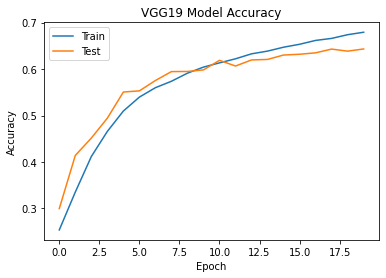

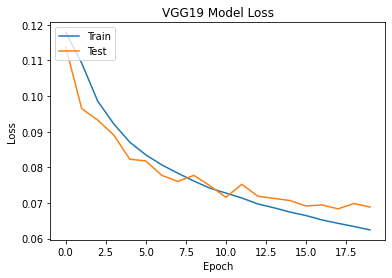

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(vgg_model_result.history['accuracy'])
plt.plot(vgg_model_result.history['val_accuracy'])
plt.title('VGG19 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('VGG19 Model Loss.png')

plt.plot(vgg_model_result.history['loss'])
plt.plot(vgg_model_result.history['val_loss'])
plt.title('VGG19 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('VGG19 Model Loss.png')